# Tuning The Model Adding Time

In [255]:
import Dathoven

In [146]:
import glob, os, fractions
import numpy as np
from matplotlib import pyplot as plt
from music21 import converter, corpus, instrument, midi, note, chord, pitch, stream, interval, duration

We define necessary functions:

In [109]:
def get_stream_from_midi_without_drums(midi_path):
    mf = midi.MidiFile()
    mf.open(midi_path)
    mf.read()
    mf.close()
    
    for i in range(len(mf.tracks)):
        mf.tracks[i].events = [ev for ev in mf.tracks[i].events if ev.channel != 10]          

    return midi.translate.midiFileToStream(mf)

def stream_to_array_of_pitches_strings (stream):
    result = []
    for element in stream.flat.notes:
        stringRepresentationOfElement = ''
        if isinstance(element, note.Note):
            stringRepresentationOfElement = element.pitch.ps
        else: # it's a chord
            stringRepresentationOfElement = [note.pitch.ps for note in element.notes][0]
            #stringRepresentationOfElement = ' '.join(listOfNotesWithOctaves)
        result.append(stringRepresentationOfElement)
    return result

def from_midi_to_array_of_pitches (midi_path):
    return stream_to_array_of_pitches_strings(get_stream_from_midi_without_drums(midi_path))

def from_pitches_to_intervals (array_of_pitches):
    intervals = []
    for i in range(1,len(array_of_pitches) - 1):
        intervals.append(array_of_pitches[i] - array_of_pitches[i-1])
    return intervals

def from_midi_to_array_of_intervals(midi_path):
    return from_pitches_to_intervals(from_midi_to_array_of_pitches(midi_path))

def get_folder_songs_intervals(folder_path):
    songs = []
    for file in glob.glob(folder_path):
        songs.append(from_midi_to_array_of_intervals(file))
    return songs

def from_array_of_intervals_to_pitches (root_pitch, intervals):
    pitches = [root_pitch]
    for interval in intervals:
        pitches.append(pitches[-1] + interval)
    return pitches

def from_pitches_to_midi (pitches, midi_path):
    streamResult = stream.Stream()
    for pitch in pitches:
            streamResult.append(note.Note(pitch))
            
    streamResult.write('midi', fp= midi_path)
    
def from_intervals_to_midi( root_pitch, intervals, midi_path):
    pitches = from_array_of_intervals_to_pitches(root_pitch, intervals)
    from_pitches_to_midi(pitches, midi_path)


def sample(preds):
    sorted_indexes = np.argsort(preds)[::-1]
    return sorted_indexes[randint(0,3)]

def sample_seq( seq, seq_length, model, output_seq_length ):
    if output_seq_length <= len(seq): raise Exception("output_seq_length must be higher than seq_length")
        
    output_seq = seq
    for i in range(output_seq_length - len(seq)):
        input_sequence = [seq[-seq_length:]]
        x = pad_sequences(input_sequence, maxlen = seq_length, padding="pre")
        prediction = model.predict(x)
        index = sample(prediction[0])
        output_seq.append(index)
    #[number_to_note(number) for number in output_seq]
    return output_seq

In [110]:
midi_test_path = 'data/examples/silent_night_easy.mid'

In [111]:
def stream_to_array_of_pitches_with_time (stream):
    result = []
    offsets = []
    for item in stream.flat.notes:
        element = []
        if isinstance(item, note.Note):
            element = item
        else: # it's a chord
            #pitch = [note.pitch.ps for note in element.notes][0]
            element = item.notes[0]
        
        resultElement = {
            'absolute_offset': element._getOffset(), 
            'pitch': element.pitch.ps, 
            'duration': element.duration.quarterLength,
            'element': element
        }
        
        if not resultElement['absolute_offset'] in offsets:  # only keep one note per time position
            result.append(resultElement)
            offsets.append(resultElement['absolute_offset'])
    result.sort(key=lambda x: x['absolute_offset'])
    return result

def from_midi_to_array_of_pitches_with_time (midi_path):
    return stream_to_array_of_pitches_with_time(get_stream_from_midi_without_drums(midi_path))

def from_pitches_to_intervals_with_time (array_of_pitches_with_time):
    intervals_with_time = []
    for i in range(1,len(array_of_pitches_with_time) - 1):
        first_element = array_of_pitches_with_time[i-1]
        second_element = array_of_pitches_with_time[i]
        resultElement = {
            'relative_offset': second_element['absolute_offset'] - first_element['absolute_offset'],
            'interval': second_element['pitch'] - first_element['pitch'],
            'duration': second_element['duration']
        }
        intervals_with_time.append(resultElement)
    return intervals_with_time

def from_midi_to_array_of_intervals_with_time(midi_path):
    return from_pitches_to_intervals_with_time(from_midi_to_array_of_pitches_with_time(midi_path))

def get_folder_songs_intervals_with_time(folder_path):
    songs = []
    for file in glob.glob(folder_path):
        songs.append(from_midi_to_array_of_intervals_with_time(file))
    return songs

In [112]:
dir(note.Note())

['_DOC_ATTR',
 '_DOC_ORDER',
 '__class__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_activeSite',
 '_activeSiteStoredOffset',
 '_classListFullyQualifiedCacheDict',
 '_classSetCacheDict',
 '_classTupleCacheDict',
 '_deepcopySubclassable',
 '_derivation',
 '_duration',
 '_editorial',
 '_getActiveSite',
 '_getDerivation',
 '_getDuration',
 '_getLyric',
 '_getMeasureOffset',
 '_getName',
 '_getNameWithOctave',
 '_getNotehead',
 '_getNoteheadFill',
 '_getNoteheadParenthesis',
 '_getOctave',
 '_getOffset',
 '_getPitches',
 '_getPriority',
 '_getQuarterLength',
 '_getSeconds',
 '_getStemDirection',
 '_getStep',
 '_getTimeSignatureF

In [113]:
from_midi_to_array_of_intervals_with_time(midi_test_path)

[{'relative_offset': 1.5, 'interval': 2.0, 'duration': 0.5},
 {'relative_offset': 0.5, 'interval': -2.0, 'duration': 1.0},
 {'relative_offset': 4.0, 'interval': 0.0, 'duration': 1.5},
 {'relative_offset': 1.5, 'interval': 2.0, 'duration': 0.5},
 {'relative_offset': 0.5, 'interval': -2.0, 'duration': 1.0},
 {'relative_offset': 1.0, 'interval': -3.0, 'duration': 2.75},
 {'relative_offset': 1.0, 'interval': -5.0, 'duration': 1.0},
 {'relative_offset': 1.0, 'interval': -2.0, 'duration': 1.0},
 {'relative_offset': 1.0, 'interval': 17.0, 'duration': 2.0},
 {'relative_offset': 2.0, 'interval': 0.0, 'duration': 1.0},
 {'relative_offset': 1.0, 'interval': -3.0, 'duration': 3.0},
 {'relative_offset': 2.0, 'interval': -16.0, 'duration': 1.0},
 {'relative_offset': 1.0, 'interval': 17.0, 'duration': 2.0},
 {'relative_offset': 2.0, 'interval': 0.0, 'duration': 1.0},
 {'relative_offset': 1.0, 'interval': -5.0, 'duration': 2.75},
 {'relative_offset': 3.0, 'interval': 2.0, 'duration': 2.0},
 {'relative

In [114]:
silent_night_deltas = from_midi_to_array_of_intervals_with_time(midi_test_path)

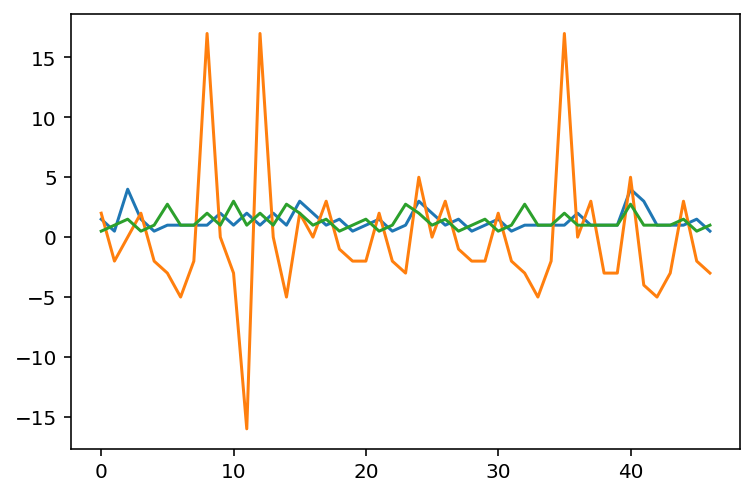

In [115]:
plt.plot(range(0, len(silent_night_deltas)), [x['relative_offset'] for x in silent_night_deltas])
plt.plot(range(0, len(silent_night_deltas)), [x['interval'] for x in silent_night_deltas])
plt.plot(range(0, len(silent_night_deltas)), [x['duration'] for x in silent_night_deltas]);

In [116]:
def from_array_of_intervals_to_pitches_with_time (root_pitch, intervals_with_time):
    elements = [{
            'absolute_offset': 0, 
            'pitch': root_pitch, 
            'duration': 1
        }]
    for interval in intervals_with_time:
        previousElement = elements[-1]
        resultElement = {
            'absolute_offset': previousElement['absolute_offset'] + interval['relative_offset'], 
            'pitch': previousElement['pitch'] + interval['interval'], 
            'duration': interval['duration'],
        }
        elements.append(resultElement)
    return elements

def from_pitches_with_time_to_midi (pitches_with_time, midi_path):
    streamResult = stream.Stream()
    for pitch_with_time in pitches_with_time:
        element = note.Note(pitch_with_time['pitch'])
        element._setOffset(pitch_with_time['absolute_offset'])
        d = duration.Duration()
        d.quarterLength = pitch_with_time['duration']
        element.duration = d
        streamResult.append(element)
            
    streamResult.write('midi', fp= midi_path)
    
def from_intervals_with_time_to_midi( root_pitch, intervals, midi_path):
    pitches_with_time = from_array_of_intervals_to_pitches_with_time(root_pitch, intervals)
    from_pitches_with_time_to_midi(pitches_with_time, midi_path)


In [117]:
#Test
from_intervals_with_time_to_midi(60, from_midi_to_array_of_intervals_with_time('data/examples/silent_night_easy.mid'),'test_intervals_with_time_silent_night.mid') 

In [119]:
songs = get_folder_songs_intervals_with_time("data/examples/*.mid")

In [259]:
songs[:1]

[[{'relative_offset': 0.5, 'interval': 0.0, 'duration': Fraction(1, 3)},
  {'relative_offset': 0.5, 'interval': 0.0, 'duration': Fraction(1, 3)},
  {'relative_offset': 0.5, 'interval': 0.0, 'duration': Fraction(1, 3)},
  {'relative_offset': 0.5, 'interval': 0.0, 'duration': Fraction(1, 3)},
  {'relative_offset': 0.5, 'interval': 0.0, 'duration': Fraction(1, 3)},
  {'relative_offset': 0.5, 'interval': 0.0, 'duration': 1.0},
  {'relative_offset': 0.5, 'interval': -27.0, 'duration': 0.5},
  {'relative_offset': 0.5, 'interval': 29.0, 'duration': Fraction(1, 3)},
  {'relative_offset': 0.5, 'interval': 0.0, 'duration': Fraction(1, 3)},
  {'relative_offset': 0.5, 'interval': 0.0, 'duration': Fraction(1, 3)},
  {'relative_offset': 0.5, 'interval': 0.0, 'duration': Fraction(1, 3)},
  {'relative_offset': 0.5, 'interval': 0.0, 'duration': Fraction(1, 3)},
  {'relative_offset': 0.5, 'interval': 0.0, 'duration': Fraction(1, 3)},
  {'relative_offset': 0.75, 'interval': 0.0, 'duration': 0.0},
  {'rel

In [257]:
len(songs)

424

Save into pickle: 

In [258]:
# Save into a pickle file.
import pickle

pickle.dump( songs, open( "songs.p", "wb" ) )

What vocabularies do we need?

For durations:

In [156]:
durations = []
[[durations.append(note['duration']) for note in song ] for song in songs];

(array([7.0639e+04, 1.3470e+03, 4.3600e+02, 6.2000e+01, 7.7000e+01,
        0.0000e+00, 4.0000e+00, 2.0000e+00, 4.0000e+00, 1.0000e+00]),
 array([0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0],
       dtype=object),
 <BarContainer object of 10 artists>)

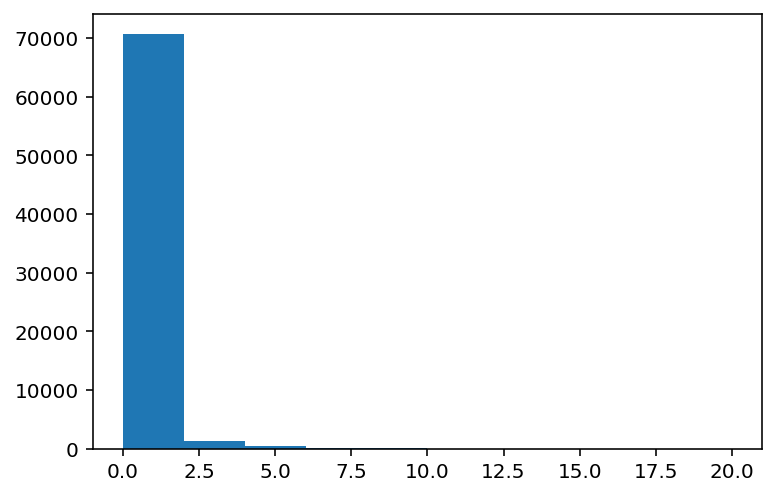

In [157]:
plt.hist(durations)

In [158]:
list(set(durations))

[0.5,
 1.0,
 0.0,
 1.5,
 0.25,
 2.5,
 2.25,
 0.75,
 1.25,
 4.0,
 8.0,
 2.0,
 4.5,
 5.0,
 1.75,
 7.5,
 3.0,
 12.0,
 3.5,
 3.25,
 2.75,
 4.25,
 4.75,
 3.75,
 15.0,
 16.0,
 5.5,
 5.75,
 5.25,
 20.0,
 6.75,
 6.0,
 6.5,
 6.25,
 7.0,
 7.75,
 8.25,
 8.75,
 Fraction(2, 3),
 Fraction(5, 3),
 Fraction(8, 3),
 Fraction(11, 3),
 Fraction(17, 3),
 Fraction(20, 3),
 13.0,
 14.5,
 Fraction(1, 3),
 Fraction(4, 3),
 Fraction(7, 3),
 Fraction(10, 3),
 Fraction(16, 3)]

In [159]:
type(songs[0][0]['duration'])

fractions.Fraction

We create a dictionary to translate from duration to positive int numbers:

In [160]:
duration_to_number = {}
number_to_duration  = {}

count=0
duration = 0
while duration <= 20:
    number_to_duration[count] = duration
    duration_to_number[duration] = count
    count+=1
    duration+=0.25

duration = 0
while duration <= 20:
    if not duration in duration_to_number:
        number_to_duration[count] = duration
        duration_to_number[duration] = count
        count+=1
    duration+=fractions.Fraction(1,3)


In [162]:
number_to_duration

{0: 0,
 1: 0.25,
 2: 0.5,
 3: 0.75,
 4: 1.0,
 5: 1.25,
 6: 1.5,
 7: 1.75,
 8: 2.0,
 9: 2.25,
 10: 2.5,
 11: 2.75,
 12: 3.0,
 13: 3.25,
 14: 3.5,
 15: 3.75,
 16: 4.0,
 17: 4.25,
 18: 4.5,
 19: 4.75,
 20: 5.0,
 21: 5.25,
 22: 5.5,
 23: 5.75,
 24: 6.0,
 25: 6.25,
 26: 6.5,
 27: 6.75,
 28: 7.0,
 29: 7.25,
 30: 7.5,
 31: 7.75,
 32: 8.0,
 33: 8.25,
 34: 8.5,
 35: 8.75,
 36: 9.0,
 37: 9.25,
 38: 9.5,
 39: 9.75,
 40: 10.0,
 41: 10.25,
 42: 10.5,
 43: 10.75,
 44: 11.0,
 45: 11.25,
 46: 11.5,
 47: 11.75,
 48: 12.0,
 49: 12.25,
 50: 12.5,
 51: 12.75,
 52: 13.0,
 53: 13.25,
 54: 13.5,
 55: 13.75,
 56: 14.0,
 57: 14.25,
 58: 14.5,
 59: 14.75,
 60: 15.0,
 61: 15.25,
 62: 15.5,
 63: 15.75,
 64: 16.0,
 65: 16.25,
 66: 16.5,
 67: 16.75,
 68: 17.0,
 69: 17.25,
 70: 17.5,
 71: 17.75,
 72: 18.0,
 73: 18.25,
 74: 18.5,
 75: 18.75,
 76: 19.0,
 77: 19.25,
 78: 19.5,
 79: 19.75,
 80: 20.0,
 81: Fraction(1, 3),
 82: Fraction(2, 3),
 83: Fraction(4, 3),
 84: Fraction(5, 3),
 85: Fraction(7, 3),
 86: Fraction(8,

In [163]:
len(number_to_duration)

121

We create a dictionary to translate from interval to positive int numbers:

We consider intervals from -100 semitones to + 100 semitones.

In [5]:
[element for element in songs[0]][:10]

[0.0, -27.0, 27.0, 0.0, -27.0, 27.0, 0.0, -27.0, 27.0, -27.0]

In [6]:
interval_to_number = {}
number_to_interval = {}

for i in range(0,100):
    interval_to_number[i] = i
    interval_to_number[-i] = 100 + i
    number_to_interval[i] = i
    number_to_interval[100+i] = -i
    

We create a dictionary to translate from relative_offset to positive int numbers:

In [171]:
offsets = []
[[offsets.append(note['relative_offset']) for note in song ] for song in songs];

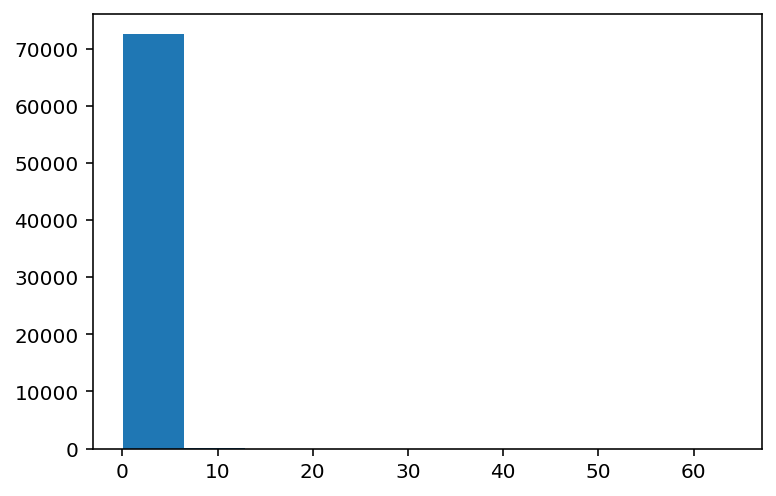

In [172]:
plt.hist(offsets);

In [173]:
list(set(offsets))

[0.5,
 0.75,
 0.25,
 3.0,
 1.5,
 1.0,
 2.0,
 2.5,
 8.5,
 3.75,
 4.666666666666668,
 1.1666666666666714,
 1.25,
 1.1666666666666572,
 5.0,
 1.75,
 8.0,
 3.5,
 2.75,
 2.25,
 3.25,
 4.5,
 4.0,
 15.75,
 16.0,
 18.25,
 5.5,
 4.25,
 5.25,
 26.0,
 5.75,
 31.0,
 32.0,
 6.5,
 6.0,
 32.5,
 7.0,
 6.25,
 32.25,
 37.0,
 7.5,
 8.25,
 7.25,
 43.5,
 9.0,
 47.75,
 9.5,
 9.666666666666671,
 12.0,
 64.0,
 13.5,
 13.0,
 15.5,
 15.0,
 16.25,
 16.5,
 0.08333333333333337,
 3.3333333333333357,
 5.333333333333314,
 0.3333333333333333,
 0.9166666666666661,
 0.6666666666666661,
 0.16666666666666607,
 0.4166666666666661,
 0.08333333333333331,
 0.08333333333331439,
 0.3333333333333144,
 0.5833333333333144,
 0.8333333333333144,
 1.666666666666666,
 1.0833333333333144,
 1.3333333333333144,
 0.16666666666666652,
 0.6666666666666665,
 0.4166666666666665,
 0.3333333333333286,
 0.5833333333333286,
 0.0833333333333286,
 0.8333333333333286,
 Fraction(2, 3),
 2.6666666666666665,
 Fraction(5, 3),
 0.16666666666666674,
 0.41

In [179]:
offsets = []
[[offsets.append(round(note['relative_offset']*4)/4) for note in song ] for song in songs];

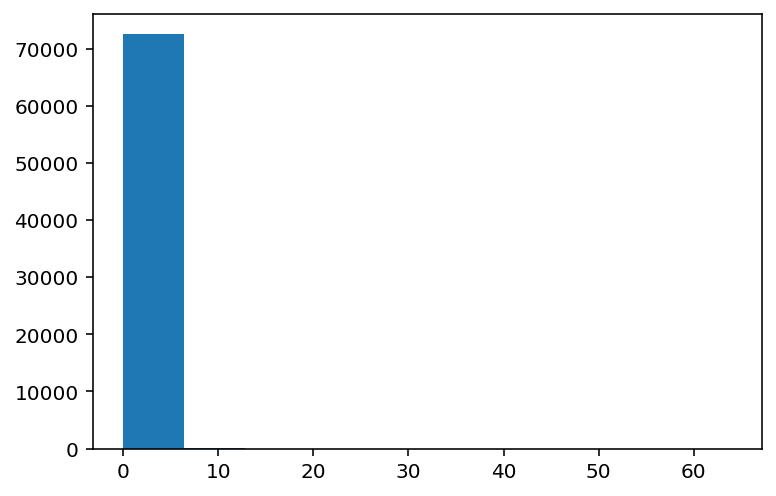

In [183]:
plt.hist(offsets);

In [181]:
list(set(offsets))

[0.5,
 0.75,
 0.25,
 3.0,
 1.5,
 1.0,
 2.0,
 2.5,
 8.5,
 3.75,
 4.75,
 1.25,
 4.5,
 5.0,
 0.0,
 1.75,
 8.0,
 3.5,
 2.75,
 2.25,
 3.25,
 4.0,
 4.25,
 15.75,
 16.0,
 18.25,
 5.5,
 5.25,
 26.0,
 5.75,
 31.0,
 32.0,
 6.5,
 6.0,
 32.5,
 7.0,
 6.25,
 32.25,
 37.0,
 7.5,
 8.25,
 7.25,
 43.5,
 8.75,
 9.0,
 47.75,
 9.5,
 9.75,
 12.0,
 64.0,
 13.5,
 13.0,
 15.5,
 15.0,
 16.25,
 16.5]

We can use the same dictionary for offsets and for durations

## Building the train set

In [36]:
train_set = [[interval_to_number[element] for element in song] for song in songs]

In [191]:
train_set = [ \
    [\
        [
         duration_to_number[round(element['relative_offset']*4)/4] if (round(element['relative_offset']*4)/4 in duration_to_number) else 1, 
         interval_to_number[element['interval']], 
         duration_to_number[element['duration']]
        ] \
    for element in song]\
for song in songs]

In [194]:
train_set[:1]

[[[2, 100, 81],
  [2, 100, 81],
  [2, 100, 81],
  [2, 100, 81],
  [2, 100, 81],
  [2, 100, 4],
  [2, 127, 2],
  [2, 29, 81],
  [2, 100, 81],
  [2, 100, 81],
  [2, 100, 81],
  [2, 100, 81],
  [2, 100, 81],
  [3, 100, 0],
  [1, 100, 0],
  [1, 100, 0],
  [1, 102, 81],
  [2, 101, 81],
  [2, 100, 81],
  [2, 100, 81],
  [2, 100, 81],
  [2, 100, 81],
  [2, 100, 81],
  [2, 102, 81],
  [2, 2, 81],
  [2, 1, 81],
  [2, 100, 81],
  [2, 100, 81],
  [2, 100, 81],
  [2, 101, 81],
  [2, 100, 81],
  [2, 100, 81],
  [2, 1, 81],
  [2, 100, 81],
  [2, 100, 81],
  [2, 100, 81],
  [2, 100, 81],
  [2, 100, 81],
  [2, 100, 4],
  [2, 127, 2],
  [2, 29, 81],
  [2, 100, 81],
  [2, 100, 81],
  [2, 100, 81],
  [2, 100, 81],
  [2, 100, 81],
  [3, 100, 0],
  [1, 100, 0],
  [1, 100, 0],
  [1, 102, 81],
  [2, 101, 81],
  [2, 100, 81],
  [2, 100, 81],
  [2, 100, 81],
  [2, 100, 81],
  [2, 100, 81],
  [2, 102, 81],
  [2, 2, 81],
  [2, 1, 81],
  [2, 100, 81],
  [2, 100, 81],
  [2, 100, 81],
  [2, 101, 81],
  [2, 100, 81]

In [228]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = np.array(sequences)[i:end_ix, :], np.array(sequences)[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [229]:
train_set[0]

[[2, 100, 81],
 [2, 100, 81],
 [2, 100, 81],
 [2, 100, 81],
 [2, 100, 81],
 [2, 100, 4],
 [2, 127, 2],
 [2, 29, 81],
 [2, 100, 81],
 [2, 100, 81],
 [2, 100, 81],
 [2, 100, 81],
 [2, 100, 81],
 [3, 100, 0],
 [1, 100, 0],
 [1, 100, 0],
 [1, 102, 81],
 [2, 101, 81],
 [2, 100, 81],
 [2, 100, 81],
 [2, 100, 81],
 [2, 100, 81],
 [2, 100, 81],
 [2, 102, 81],
 [2, 2, 81],
 [2, 1, 81],
 [2, 100, 81],
 [2, 100, 81],
 [2, 100, 81],
 [2, 101, 81],
 [2, 100, 81],
 [2, 100, 81],
 [2, 1, 81],
 [2, 100, 81],
 [2, 100, 81],
 [2, 100, 81],
 [2, 100, 81],
 [2, 100, 81],
 [2, 100, 4],
 [2, 127, 2],
 [2, 29, 81],
 [2, 100, 81],
 [2, 100, 81],
 [2, 100, 81],
 [2, 100, 81],
 [2, 100, 81],
 [3, 100, 0],
 [1, 100, 0],
 [1, 100, 0],
 [1, 102, 81],
 [2, 101, 81],
 [2, 100, 81],
 [2, 100, 81],
 [2, 100, 81],
 [2, 100, 81],
 [2, 100, 81],
 [2, 102, 81],
 [2, 2, 81],
 [2, 1, 81],
 [2, 100, 81],
 [2, 100, 81],
 [2, 100, 81],
 [2, 101, 81],
 [2, 100, 81],
 [2, 100, 81],
 [6, 1, 81],
 [2, 100, 81],
 [2, 100, 81],
 [2,

In [230]:
X, y = split_sequences(train_set[0], 3)

In [231]:
X

array([[[  2, 100,  81],
        [  2, 100,  81],
        [  2, 100,  81]],

       [[  2, 100,  81],
        [  2, 100,  81],
        [  2, 100,  81]],

       [[  2, 100,  81],
        [  2, 100,  81],
        [  2, 100,  81]],

       ...,

       [[  2,   1,  81],
        [  2, 100,  81],
        [  2, 100,  81]],

       [[  2, 100,  81],
        [  2, 100,  81],
        [  2, 100,  81]],

       [[  2, 100,  81],
        [  2, 100,  81],
        [  2, 101,  81]]])

In [232]:
def slice_sequence_examples(sequence, num_steps):
    """Slice a sequence into redundant sequences of lenght num_steps."""
    xs = []
    for i in range(len(sequence) - num_steps - 1):
        example = sequence[i: i + num_steps]
        xs.append(example)
    return xs

def seq_to_singleton_format(examples):
    """
    Return the examples in seq to singleton format.
    """
    xs = []
    ys = []
    for ex in examples:
        xs.append(ex[:-1])
        ys.append(ex[-1])
    return (xs,ys)

In [233]:
SEQ_LEN = 30
BATCH_SIZE = 64
HIDDEN_UNITS = 256
EPOCHS = 50
VOCABULARY_SIZE = 201

In [234]:
VOCABULARY_SIZE

201

In [235]:
# Slice the sequences:
slices = []
for seq in train_set:
    slices +=  slice_sequence_examples(seq, SEQ_LEN+1)

# Split the sequences into Xs and ys:
X, y = seq_to_singleton_format(slices)
# Convert into numpy arrays.
X = np.array(X)
y = np.array(y)

In [236]:
X.shape

(59968, 30, 3)

We build the model:

In [237]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM, Dropout
from keras.layers.embeddings import Embedding
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint

We sample:

In [238]:
from random import randint
def sample(preds):
    sorted_indexes = np.argsort(preds)[::-1]
    return sorted_indexes[randint(0,3)]

In [239]:
def sample_seq( seq, seq_length, model, number_to_note, output_seq_length ):
    if output_seq_length <= len(seq): raise Exception("output_seq_length must be higher than seq_length")
        
    output_seq = seq
    for i in range(output_seq_length - len(seq)):
        input_sequence = [seq[-seq_length:]]
        x = pad_sequences(input_sequence, maxlen = seq_length, padding="pre")
        prediction = model.predict(x)
        index = sample(prediction[0])
        output_seq.append(index)
    #[number_to_note(number) for number in output_seq]
    return output_seq

Probando map: 

In [242]:
from keras.metrics import Precision
from keras.metrics import SparseTopKCategoricalAccuracy

In [243]:

HIDDEN_UNITS = 50
EPOCHS = 10
VOCABULARY_SIZE = 201

In [250]:
print('Build model...')
model_interval_with_time = Sequential()

# LSTM part
model_interval_with_time.add(LSTM(HIDDEN_UNITS, return_sequences=True, input_shape=(SEQ_LEN, 3)))
model_interval_with_time.add(LSTM(HIDDEN_UNITS))

# Project back to vocabulary
#model_interval_with_time.add(Dense(VOCABULARY_SIZE, activation='softmax'))
model_interval_with_time.add(Dense(3))

#model_interval.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy'])#metrics=[Precision(top_k=10)])
#model_interval.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=[Precision(top_k=10)])
#model_interval_with_time.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=[SparseTopKCategoricalAccuracy(k=10, name='sparse_top_k_categorical_accuracy')])

model_interval_with_time.compile(optimizer='adam', loss='mse')

model_interval_with_time.summary()

Build model...
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 30, 50)            10800     
_________________________________________________________________
lstm_12 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 153       
Total params: 31,153
Trainable params: 31,153
Non-trainable params: 0
_________________________________________________________________


In [251]:
# checkpoint
filepath="models_checkpoints/weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, mode='min')
callbacks_list = [checkpoint]

In [252]:
# Fit the model
history = model_interval_with_time.fit(X, y, validation_split = 0.1,  batch_size=BATCH_SIZE, epochs=10, callbacks=callbacks_list)


Train on 53971 samples, validate on 5997 samples
Epoch 1/10
53971/53971 [==============================] - 73s 1ms/step - loss: 1620.9913 - val_loss: 1375.2242

Epoch 00001: saving model to models_checkpoints/weights-improvement-01-1375.22.hdf5
Epoch 2/10
53971/53971 [==============================] - 71s 1ms/step - loss: 1029.9226 - val_loss: 1138.3470

Epoch 00002: saving model to models_checkpoints/weights-improvement-02-1138.35.hdf5
Epoch 3/10
53971/53971 [==============================] - 71s 1ms/step - loss: 936.3716 - val_loss: 1088.6296

Epoch 00003: saving model to models_checkpoints/weights-improvement-03-1088.63.hdf5
Epoch 4/10
53971/53971 [==============================] - 71s 1ms/step - loss: 866.5593 - val_loss: 990.4141

Epoch 00004: saving model to models_checkpoints/weights-improvement-04-990.41.hdf5
Epoch 5/10
53971/53971 [==============================] - 71s 1ms/step - loss: 779.1200 - val_loss: 918.5238

Epoch 00005: saving model to models_checkpoints/weights-impro

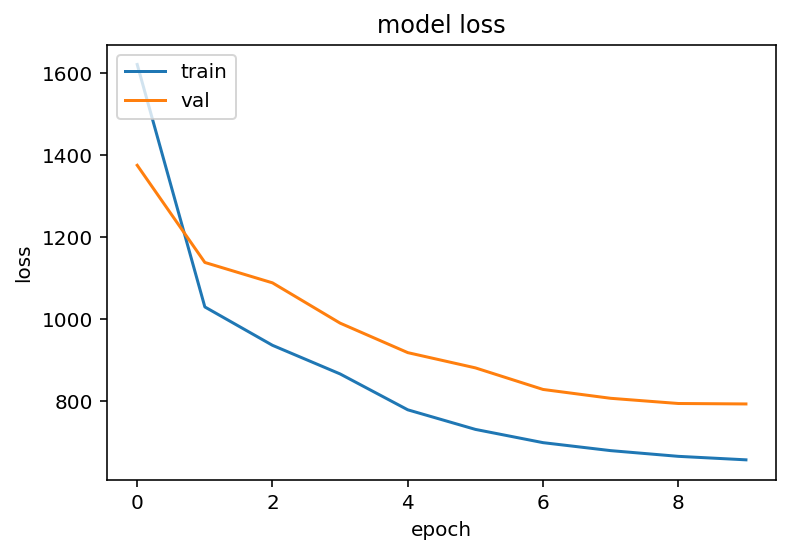

In [254]:
plt.plot(model_interval_with_time.history.history['loss'])
plt.plot(model_interval_with_time.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [49]:
from keras.losses import SparseCategoricalCrossentropy

In [50]:
SparseCategoricalCrossentropy

keras.losses.SparseCategoricalCrossentropy

In [51]:
model_interval.load_weights('models_checkpoints/weights-improvement-10-2.87.hdf5')

In [55]:
generated_vector = sample_seq([1], SEQ_LEN, model_interval, number_to_interval, 50)
generated_intervals = [number_to_interval[number] for number in generated_vector]

In [59]:
from datetime import datetime

In [60]:
datetime.now().strftime("%Y%m%d_%H%M%S")

'20210620_205756'

In [61]:
from datetime import datetime
datetime.now()

datetime.datetime(2021, 6, 20, 20, 57, 58, 363034)

In [62]:
from_intervals_to_midi(70, generated_intervals, datetime.now().strftime("%Y%m%d_%H%M%S")+'_generated_record_intervals_tuning.mid') 